<a href="https://colab.research.google.com/github/arielisaac/AI_udacity_class/blob/main/project_1/LightweightFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* PEFT technique:
* Model:
* Evaluation approach:
* Fine-tuning dataset:

## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [1]:
!pip install transformers datasets peft accelerate evaluate optuna


Looking in indexes: https://nexus.corp.indeed.com/repository/pypi/simple


## A few Configurations

In [2]:
import torch
# Disable torch.compile for stability
torch._dynamo.config.disable = True

# This is to improve performance on M1 Macs
def get_best_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_best_device()

# ModernBERT blog: https://www.answer.ai/posts/2024-12-19-modernbert.html
# Philipp Schmid's blog on Fine-Tuning open LLMs: https://www.philschmid.de/fine-tune-llms-in-2025

# https://learn.udacity.com/nanodegrees/nd101-ent-ai-swe-indeed/parts/cd13303/lessons/786df5de-95ad-4e0d-be51-cc8a1c1e40fe/concepts/ed4cd691-b999-454e-b715-a603fb2aeeb5?lesson_tab=lesson
# https://huggingface.co/docs/peft/main/en/conceptual_guides/lora

# Necessary imports
from datasets import load_dataset
from peft import (AutoPeftModelForSequenceClassification,
                  LoraConfig,
                  get_peft_model,
                  TaskType)
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          DataCollatorWithPadding,
                          Trainer,
                          TrainingArguments)
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)

## Loading the Dataset

In [3]:

from datasets import load_dataset

# # Another dataset availabe: sms_spam
# sms_spam_dataset = load_dataset("sms_spam", split=["train"])[0]
# print(sms_spam_dataset)
# # Split the dataset into train and test sets (assuming `dataset` is a Hugging Face Dataset object)
# sms_spam_dataset_train_test_split = sms_spam_dataset.train_test_split(test_size=0.2, seed=42)
# test_dataset = sms_spam_dataset_train_test_split['test']
# print(sms_spam_dataset[:5])
# """
# Convert the dataset to a pandas DataFrame
# """
# import pandas as pd

# # Convert the entire dataset to a pandas DataFrame
# df = pd.DataFrame(sms_spam_dataset)
# # Display the first 10 rows
# print(df.head(10))

# # Or for more detailed information
# display(df.head(10))  # Works in Jupyter notebooks
# display(df.describe())  # Works in Jupyter notebooks

# for entry in dataset.select(range(3)):
#     sms = entry["sms"]
#     label = entry["label"]
#     print(f"label={label}, sms={sms}")


# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds_imdb = {split: ds for split, ds in zip(splits, load_dataset("imdb", split=splits))}


# Thin out the dataset to make it run faster for this example
for split in splits:
    ds_imdb[split] = ds_imdb[split].shuffle(seed=42).select(range(500))
print(ds_imdb)

# Count the number of positive and negative reviews in each split
for split in splits:
    # Count negative reviews (label = 0)
    negative_count = sum(1 for item in ds_imdb[split] if item['label'] == 0)
    # Count positive reviews (label = 1)
    positive_count = sum(1 for item in ds_imdb[split] if item['label'] == 1)
    total = len(ds_imdb[split])

    print(f"{split} split:")
    print(f"  Negative reviews (label=0): {negative_count} ({negative_count/total:.2%})")
    print(f"  Positive reviews (label=1): {positive_count} ({positive_count/total:.2%})")
    print()




{'train': Dataset({
    features: ['text', 'label'],
    num_rows: 500
}), 'test': Dataset({
    features: ['text', 'label'],
    num_rows: 500
})}
train split:
  Negative reviews (label=0): 254 (50.80%)
  Positive reviews (label=1): 246 (49.20%)

test split:
  Negative reviews (label=0): 254 (50.80%)
  Positive reviews (label=1): 246 (49.20%)



## Loading the Model and Tokenizing the dataset

In [4]:
#Models
# Very good documentation  https://huggingface.co/transformers/v4.2.2/training.html

from transformers import AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
def return_model(model_name = "distilbert-base-uncased"):
    model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},  # For converting predictions to strings
    label2id={"NEGATIVE": 0, "POSITIVE": 1},)
    model.to(device)
    return model

model = return_model()
print(model)

#Tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    """Preprocess the imdb dataset by returning tokenized examples."""
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

tokenized_ds = {}
for split in splits:
    tokenized_ds[split] = ds_imdb[split].map(preprocess_function, batched=True)

tokenized_test = ds_imdb["test"].map(preprocess_function, batched=True)

# Check that we tokenized the examples properly
assert tokenized_ds["train"][0]["input_ids"][:5] == [101, 2045, 2003, 2053, 7189]

# Show the first example of the tokenized training set
print(tokenized_ds["train"][0]["input_ids"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Evaluating the pre trained (model not trained yet)

/var/folders/wk/pzcwnxxn535cgj1v_p1p_m140000gn/T/ipykernel_30654/218274993.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.6958169937133789, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.508, 'eval_runtime': 6.081, 'eval_samples_per_second': 82.223, 'eval_steps_per_second': 20.556}

Evaluating Base Model Set


              precision    recall  f1-score   support

    Negative       0.51      1.00      0.67       254
    Positive       0.00      0.00      0.00       246

    accuracy                           0.51       500
   macro avg       0.25      0.50      0.34       500
weighted avg       0.26      0.51      0.34       500



/Users/arcartaya/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

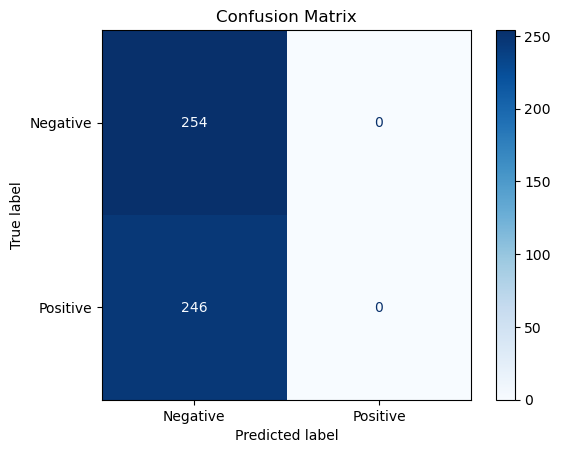


Accuracy: 0.508
F1 result: 0.0
Recall: 0.0


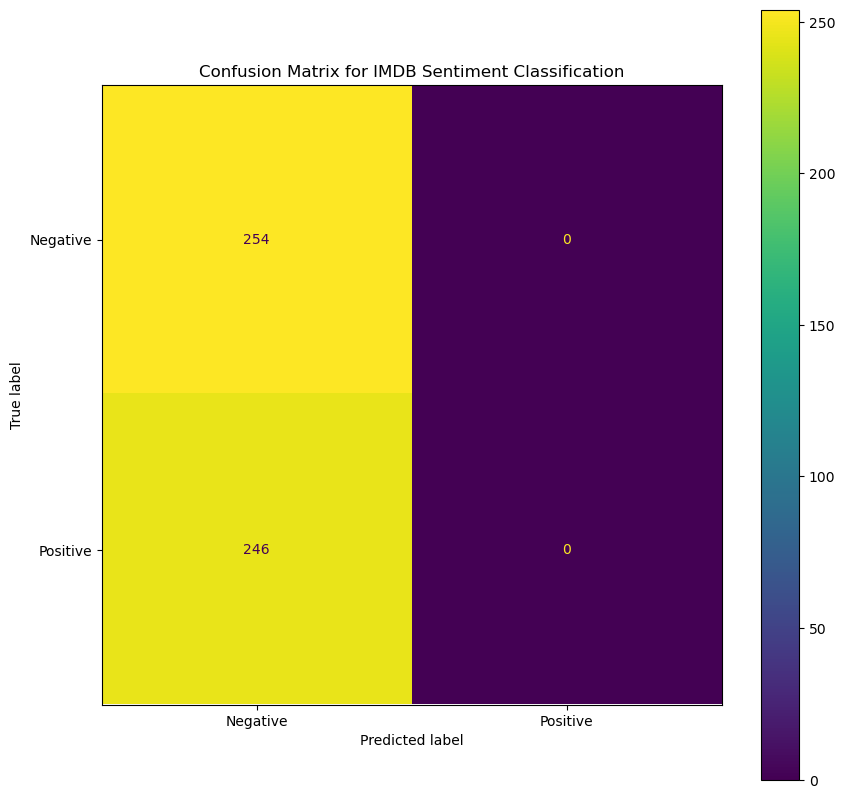

In [5]:
from sklearn.metrics import accuracy_score, f1_score,  precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

labels = ["Negative", "Positive"]
# 3.2 Evaluate base model before fine-tuning
def evaluate_model(model, dataset_split, split_name="Test"):
    print(f"\n{'='*40}")
    print(f"Evaluating {split_name} Set")
    print(f"{'='*40}")

    # Define evaluation arguments
    eval_args = TrainingArguments(
        output_dir="./pre_fine_tuning_results",
        report_to="none"  # Disable all logging integrations, including wandb
    )

    trainer = Trainer(
        args=eval_args,
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        processing_class=tokenizer
    )

    outputs = trainer.predict(dataset_split)
    predictions = np.argmax(outputs.predictions, axis=1)
    labels = outputs.label_ids

    print(classification_report(labels, predictions, target_names=["Negative", "Positive"]))
    plot_confusion_matrix(labels, predictions)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()



def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./result-distilbert-base",
        per_device_eval_batch_size=4,
        report_to="none"
    ),
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
pre_finetune_eval = trainer.evaluate()
print(pre_finetune_eval)

# Pre-training evaluation on the tokenized dataset
evaluate_model(model, tokenized_ds["test"], "Base Model")


"""
My own version
"""


# Make predictions
predictions = []
true_labels = []

with torch.no_grad():
    for i in range(len(tokenized_test)):
        inputs = {
            "input_ids": torch.tensor(tokenized_test[i]["input_ids"]).unsqueeze(0).to(device),
            "attention_mask": torch.tensor(tokenized_test[i]["attention_mask"]).unsqueeze(0).to(device),
        }
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_label)
        true_labels.append(tokenized_test[i]["label"])

# Evaluate the predictions
accuracy = accuracy_score(true_labels, predictions)
f1_result = f1_score(true_labels, predictions)

print()
print(f"Accuracy: {accuracy}")
print(f"F1 result: {f1_result}")
print(f"Recall: {recall_score(true_labels, predictions)}")


# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
labels = ["Negative", "Positive"]  # IMDB sentiment labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title("Confusion Matrix for IMDB Sentiment Classification")
plt.show()

# Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.htweight Fine-Tuning

## Create the PEFT model

In [6]:
# Unfreeze all the model parameters.
# Hint: Check the documentation at https://huggingface.co/transformers/v4.2.2/training.html
model = return_model()

for param in model.parameters():
    param.requires_grad = True
# Helper function to find all linear layer names
def find_linear_layers(model):
    linear_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            linear_layers.append(name)
    return linear_layers

# Get the actual linear layer names in your model
linear_layers = find_linear_layers(model)
print("Linear layers found:", linear_layers)
print(model)
from peft import LoraConfig
# https://huggingface.co/docs/peft/main/en/conceptual_guides/lora
# https://huggingface.co/docs/peft/main/en/task_guides/image_classification_lora
config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
    # Use a more general approach to find linear layers
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj", "lin1", "lin2", "classifier"],
    modules_to_save=["classifier"],
    )

from peft import get_peft_model
lora_model = get_peft_model(model, config)

lora_model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear layers found: ['distilbert.transformer.layer.0.attention.q_lin', 'distilbert.transformer.layer.0.attention.k_lin', 'distilbert.transformer.layer.0.attention.v_lin', 'distilbert.transformer.layer.0.attention.out_lin', 'distilbert.transformer.layer.0.ffn.lin1', 'distilbert.transformer.layer.0.ffn.lin2', 'distilbert.transformer.layer.1.attention.q_lin', 'distilbert.transformer.layer.1.attention.k_lin', 'distilbert.transformer.layer.1.attention.v_lin', 'distilbert.transformer.layer.1.attention.out_lin', 'distilbert.transformer.layer.1.ffn.lin1', 'distilbert.transformer.layer.1.ffn.lin2', 'distilbert.transformer.layer.2.attention.q_lin', 'distilbert.transformer.layer.2.attention.k_lin', 'distilbert.transformer.layer.2.attention.v_lin', 'distilbert.transformer.layer.2.attention.out_lin', 'distilbert.transformer.layer.2.ffn.lin1', 'distilbert.transformer.layer.2.ffn.lin2', 'distilbert.transformer.layer.3.attention.q_lin', 'distilbert.transformer.layer.3.attention.k_lin', 'distilbert.tr

## Train the PEFT model

In [7]:
from transformers import TrainingArguments, Trainer

batch_size = 1

import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

lora_model.gradient_checkpointing_enable()

trainer = Trainer(
    model=lora_model,
    args= TrainingArguments(
        f"{model_name}-finetuned-lora-101",
        remove_unused_columns=False,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-3,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=batch_size,
        fp16=False,
        num_train_epochs=15,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        push_to_hub=False,
        label_names=["labels"],
        report_to="none",
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    #tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()


/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.553600,0.565007,0.784000
2,0.549700,0.546013,0.788000
3,0.657100,0.493979,0.812000
4,0.441700,0.472627,0.808000
5,0.698900,0.563756,0.798000
6,0.569700,0.480719,0.784000
7,0.314200,0.539339,0.770000
8,0.515100,0.580720,0.766000
9,0.486800,0.478500,0.828000
10,0.228900,0.435800,0.822000


/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.

## Save the PEFT model
###  ⚠️ IMPORTANT ⚠️

Due to workspace storage constraints, you should not store the model weights in the same directory but rather use `/tmp` to avoid workspace crashes which are irrecoverable.
Ensure you save it in /tmp always.

In [8]:
model_name_id = f"{model_name}-finetuned-lora-101"
lora_model.save_pretrained(model_name_id)


## Performing Inference with a PEFT Model

### Load the saved PEFT model


TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [9]:
from peft import AutoPeftModelForSequenceClassification, PeftModelForSequenceClassification
# Load the base model first
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Then, load the PEFT model using the base model
lora_model_load = PeftModelForSequenceClassification.from_pretrained(base_model, model_name_id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluate the fine-tuned model

/var/folders/wk/pzcwnxxn535cgj1v_p1p_m140000gn/T/ipykernel_30654/2984703162.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


{'eval_loss': 0.4784998297691345, 'eval_model_preparation_time': 0.0011, 'eval_accuracy': 0.828, 'eval_runtime': 6.1235, 'eval_samples_per_second': 81.652, 'eval_steps_per_second': 20.413}

Evaluating Base Model Set


              precision    recall  f1-score   support

    Negative       0.84      0.81      0.83       254
    Positive       0.81      0.85      0.83       246

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



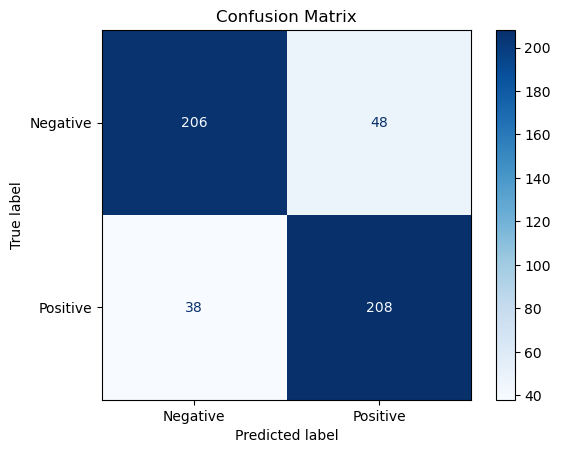

In [10]:
trainer = Trainer(
    model=lora_model_load,
    args=TrainingArguments(
        output_dir="./result-distilbert-base",
        per_device_eval_batch_size=4,
        report_to="none"
    ),
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
post_finetune_eval = trainer.evaluate()
print(post_finetune_eval)

# Pre-training evaluation on the tokenized dataset
evaluate_model(lora_model_load, tokenized_ds["test"], "Base Model")